# Predictive Coding

In [1]:
import numpy as np
import nengo
from copy import deepcopy
import matplotlib.pyplot as plt
# import torch
# import torch.nn as nn

# `PCLayer` class
This class models both the value nodes and error nodes of a single layer, as well as their interactions.

In [2]:
class PCLayer(nengo.Network):
    '''
    l = PCLayer(n_nodes=10, tau=0.01)

    Creates a layer for a predictive-coding network.
    This layer has an array of value nodes, and a corresponding array of error nodes.

    Inputs:
    n_nodes       number of nodes in the layer
    tau           synaptic time constant for internal error->value connections
    pred_layer    is this a prediction layer
    '''
    def __init__(self, n_nodes=10, tau=0.01, pred_layer=False):
        self.label = 'PCLayer'
        self.n_nodes = n_nodes
        self.pred_layer = pred_layer
        self.tau = tau
        self.inference_node = None

        # When the network is run in using the "Direct" neuron model, it treats
        # each "Ensemble" as a single variable, and the decodings are done by
        # the user-supplied decoding functions, not using decoding weights.
        # In this case, the "n_neurons" argument is ignored.

        # An "EnsembleArray" can be thought of as a group of nodes.
        # An EnsembleArray holding the values (v)
        self.v = nengo.networks.EnsembleArray(n_neurons=50, n_ensembles=n_nodes, radius=1.5)
        # and an EnsembleArray holding the errors (e)
        self.e = nengo.networks.EnsembleArray(n_neurons=50, n_ensembles=n_nodes, radius=1.5)

        #node in between e and v for inference

        nengo.Connection(self.v.output, self.v.input, transform=1, synapse=tau)               # sustain old state

        if self.pred_layer:
            self.pass_through = nengo.Node(self.step, size_in=n_nodes, size_out=n_nodes)   #pass-through node between (e) and (v)
            nengo.Connection(self.e.output, self.pass_through, transform=tau, synapse=tau)            # (v)<-(e)                                               
            nengo.Connection(self.pass_through, self.v.input, transform=-tau, synapse=tau) 
        else:           
            nengo.Connection(self.e.output, self.v.input, transform=-tau, synapse=tau)            
        nengo.Connection(self.v.output, self.e.input, transform=tau, synapse=tau)                            # (v)->(e)

    def step(self, t, x):
        if t > 0 and self.inference_node.output(t) == 0: #simply pass through the input
            return x
        else: #either initial step or we are doing inference, block input
            if hasattr(x, '__len__'): #input with length
                return [0 for i in range(len(x))]
            else: #should just be an int or float
                return 0

# `PCConnection` class
This class models the weighted, all-to-all connections between `PCLayer`s.

In [3]:
class Updater(nengo.Process):
    """
    Extends the nengo.Process class to be used in the PCConnection class. 
    A PCConnection instance will create an Updater during initialization.

    connection_class     The instance of the PCConnection class that created this Updater.
    """
    def __init__(self, connection_class, **kwargs):
        super().__init__(default_size_in=0, **kwargs)
        self.connection_class = connection_class
        self.shape_in = self.connection_class.n_e + self.connection_class.n_v
        self.shape_out = self.connection_class.n_e + self.connection_class.n_v
    

    def __repr__(self):
        return "Updater"
    

    def make_step(self, shape_in, shape_out, dt, rng, state):
        """
        Creates a function that will used at every time step in order to evaluate the output of the Updater.
        """
        def step_updater(t, x):
            e_in = x[:self.connection_class.n_e]
            v_in = x[self.connection_class.n_e:]

            err_out = self.connection_class.deriv(v_in) * (e_in @ self.connection_class.W)
            pred_out = self.connection_class.func(v_in) @ self.connection_class.M

            if self.connection_class.inference_node.output(t) == 0: #not doing inference, so we learn
                dM = np.outer(self.connection_class.func(v_in), e_in)
                #print("tau learn", self.connection_class.tau_learn)
                #print("dM", dM)
                #print("M", self.M)
                self.connection_class.M += dt * dM / self.connection_class.tau_learn
                if not self.connection_class.symmetric:
                    self.connection_class.W += dt * dM.T / self.connection_class.tau_learn

            return np.concatenate((pred_out, err_out)) 
        return step_updater

In [4]:
class PCConnection(nengo.Network):
    '''
     c = PCConnection(below, above, learn=False, symmetric=True)
     
     This class builds all the connections between the two PCLayers.
     
     Inputs:
      below        PCLayer object below
      above        PCLayer object above
      learn        Boolean, whether to learn (default False)
      symmetric    Boolean, whether the connection is symmetric
                   ie. W = M.T (default True)
      activation  Activation function to use. None defaults to linear
    '''
    def __init__(self, below, above, inference_node=None, tau_learn=20., symmetric=True, M=None, activation=None):
        self.below = below
        self.above = above
        self.tau_learn = tau_learn    # learning time constant
        self.symmetric = symmetric
        self.n_e = self.below.e.n_ensembles  # dimension of below layer
        self.n_v = self.above.v.n_ensembles  # dimension of above layer

        self.inference_node = inference_node #we will learn if and only if not doing inference
        self.updater = Updater(self) #internal node we use to apply the Euler step for updating weights

        if activation is None: #Linear Activation
            self.func = lambda x: x
            self.deriv = lambda x: np.ones_like(x)
        elif activation=="ReLU":
            self.func = lambda x: np.maximum(0, x)
            self.deriv = lambda x: (np.sign(x)+1)/2
        elif activation=="logistic":
            self.func = lambda x: 1/(1 + np.exp(-x))
            self.deriv = lambda x: self.func(x)*(1-self.func(x))
        elif activation=="tanh":
            self.func = lambda x: np.tanh(x)
            self.deriv = lambda x: 1 - np.tanh(x)**2
        elif activation=="threshold":
            self.func = lambda x: (np.sign(x)+1)/2
            self.deriv = lambda x: np.zeros_like(x)
        else:
            raise ValueError("Unknown activation function. Acceptable inputs are: None, "
                             + "\"ReLU\", "
                             + "\"logistic\", "
                             + "\"tanh\", "
                             + f"or \"threshold\". Got \"{activation}\".")


        # Set up connect matrices
        if M is None:
            self.M = np.random.normal(size=(self.n_v, self.n_e))/10.
        else:
            self.M = M
        if self.symmetric:
            self.W = self.M.T
        else:
            self.W = np.random.normal(size=(self.n_e, self.n_v))


        # Set up the node that applies the connection weights
        dims = self.n_e + self.n_v
        #self.exchange = nengo.Node(Updater(self), size_in=dims, size_out=dims)
        self.exchange = nengo.Node(self.updater, size_in=dims, size_out=dims)
        

        n = self.n_e
        nengo.Connection(self.below.e.output, self.exchange[:n], synapse=0)               # inp -> exchange
        nengo.Connection(self.exchange[:n], self.below.e.input, transform=-1)  # inp <- con
        nengo.Connection(self.above.v.output, self.exchange[n:], transform=1, synapse=0)  # con <- hid
        nengo.Connection(self.exchange[n:], self.above.v.input)                # con -> hid
        

    def update(self, t, x):
        """
        # Original update rule without nonlinearity
        e_in = x[:self.n_e]
        v_in = x[self.n_e:]

        err_out = self.deriv(v_in) * (self.W @ e_in)
        pred_out = self.M @ self.func(v_in)

        if self.learn:
            dM = np.outer(e_in, self.func(v_in))
            self.M += dM / self.tau_learn
            if not self.symmetric:
                self.W += dM.T / self.tau_learn

        return np.concatenate((pred_out, err_out))
        """
        e_in = x[:self.n_e]
        v_in = x[self.n_e:]

        err_out = self.deriv(v_in) * (e_in @ self.W)
        pred_out = self.func(v_in) @ self.M

        if self.inference_node.output(t) == 0: #not doing inference, so we learn
            dM = np.outer(self.func(v_in), e_in)
            #print("tau learn", self.tau_learn)
            #print("dM", dM)
            #print("M", self.M)
            self.M += dM / self.tau_learn
            if not self.symmetric:
                self.W += dM.T / self.tau_learn

        return np.concatenate((pred_out, err_out))   


# `PCNetwork` class
This class creates a predictive coding neural network made of `PCLayer`s.

In [5]:
class PCNetwork:
    '''
    This class builds a PC neural network with.
    
    Inputs:
    n_nodes               List, the of number of nodes at each hidden layer
    learn                 Boolean, whether to learn (default False)
    symmetric             Boolean, whether the connection is symmetric
                          ie. W = M.T (default True)
    tau_learn             num or List, learning rate for the Euler step when updating the weights
                            - if num, each connection will have the same tau_learn
                            - if List, each connection will have a tau_learn corresponding to the value in that
                              position in the list
    M                     ndarray, List or None, value of M at each layer, defaults to None
                            - if ndarray or None, each connection will have M passed in as an argument during construction
                            - if List, each connection will have an M corresponding to the value in that
                              position in the list
    activation            None, string, or list, defaults to None
                            - if string or None, each connection will have the same activation function
                            - if list, each connection will have an activation fucntion corresponding to the value
                              in that position in the list
    t                     Num, the amount of simulation time to spend learning connection weights, defaults to 0
    '''
    def __init__(self, n_nodes=None, symmetric=True, tau_learn=10., M=None, activation=None, t=0):
        if n_nodes is None:
            n_nodes = []
        elif type(n_nodes) is not list:
            raise TypeError(f"n_nodes must be a list or an int, instead got {type(n_nodes)}")
        else:
            self.n_nodes = n_nodes
        self.num_hidden_layers = len(self.n_nodes)
        self.layers = [] #a list of all layers in order of connection
        self.connections = [] #a list of all connections between layers
        self.symmetric = symmetric
        self.t = t
        self.inference_node = nengo.Node(self.inference_output)

        #set up member attributes and input validation
        if type(tau_learn) is int or type(tau_learn) is float:
            self.tau_learn = [tau_learn for i in range(self.num_hidden_layers-1)]   # learning time constant
        elif type(tau_learn) is not list:
            raise TypeError(f"tau_learn must be a list or an int/float, instead got {type(tau_learn)}")
        else:
            if len(tau_learn) != self.num_hidden_layers-1:
                raise ValueError(f"If tau is a list, it must have {self.num_hidden_layers-1}, instead got {len(tau_learn)}")
            self.tau_learn = tau_learn
  
        if type(M) is np.ndarray or M is None:
            self.M = [M for i in range(self.num_hidden_layers-1)]
        elif type(M) is not list:
            raise TypeError(f"M must be an ndarray, list, or None, instead got {type(M)}")
        else:
            if len(M) != self.num_hidden_layers-1:
                raise ValueError(f"If M is a list, it must have {self.num_hidden_layers-1} elements, instead got {len(M)}")
            self.M = M
        
        if type(activation) is str or activation is None:
            self.activation = [activation for i in range(self.num_hidden_layers-1)]
        elif type(activation) is not list:
            raise TypeError(f"activation must be a list, string, or None, instead got {type(activation)}")
        else:
            if len(activation) != self.num_hidden_layers-1:
                raise ValueError(f"If activation is a list, it must have {self.num_hidden_layers-1} elements, instead got {len(activation)}")
            self.activation = activation
        
        #create hidden layers
        self.layers.append(PCLayer(n_nodes=self.n_nodes[0]))
        for i in range(1, self.num_hidden_layers-1): #create and connect the rest of the layers
            self.layers.append(PCLayer(n_nodes=self.n_nodes[i]))
            self.connections.append(PCConnection(self.layers[i-1], 
                                                 self.layers[i], 
                                                 inference_node=self.inference_node, 
                                                 symmetric=self.symmetric,
                                                 M=self.M[i-1],
                                                 tau_learn=self.tau_learn[i-1],
                                                 activation=self.activation[i-1]))
        #prediction layer
        self.layers.append(PCLayer(n_nodes=self.n_nodes[-1], pred_layer=True))
        self.connections.append(PCConnection(self.layers[-2], 
                                                self.layers[-1], 
                                                inference_node=self.inference_node, 
                                                symmetric=self.symmetric,
                                                M=self.M[-1],
                                                tau_learn=self.tau_learn[-1],
                                                activation=self.activation[-1]))

            

    def inference_output(self, time):
        if time < self.t: #not inference, training
            return 0
        else: #inference
            return 1
     
            
    def connect_input(self, stim):
        """ (self, nengo.Node) -> ()
        Connects the input (stimulus) layer to the first hidden layer of the network.
        """
        D = stim.size_out #dimensionality of inputs to the the network
        
        if self.n_nodes[0] != D:
            raise ValueError("Dimensionality of the input does not match the dimensionality of the first layer.")
        
        stim_err = nengo.Node(lambda t,x: x[:D]+x[D:], size_in=2*D, size_out=D)  # sensory error
        nengo.Connection(stim, stim_err[:D], synapse=None)                                 # stim -> stim_err
        nengo.Connection(stim_err, self.layers[0].v.input)                   # stim_err -> first layer
        nengo.Connection(self.layers[0].v.output, stim_err[D:], transform=-1) # stim_err <- first layer

    
    def connect_output(self, pred):
        """ (self, nengo.Node, num) -> ()
        Connects the output (prediction) layer to the last hidden layer of the network. 
        """
        if self.n_nodes[-1] != pred.size_out:
            raise ValueError("Dimensionality of the target does not match the dimensionality of the last layer.")
         
        self.layers[-1].inference_node = self.inference_node
        nengo.Connection(pred, self.layers[-1].e.input, transform=-1)         # pc2 <- pred
    

    def update_learning_rule(self, learning_rule):
        """ (self, bool) -> ()
        Changes the learning rule for each connection is self.connections to learning_rule
        """
        for con in self.connections:
            con.learn = learning_rule

    
    def get_probes(self):
        """ (self) -> (list, list)
        Returns a list of nengo.Probes to track each layers values and errors.

        ##### NOT GREAT WHEN DIMENSIONALITY OF INPUT IS MORE THAN 1
        """
        val_probes = []
        err_probes = []
        for idx, layer in enumerate(self.layers):
            val_probes.append(nengo.Probe(layer.v.output, label=f"Hidden Layer {idx} Value"))
            err_probes.append(nengo.Probe(layer.e.output, label=f"Hidden Layer {idx} Error"))
        return val_probes, err_probes

        

In [6]:
# same test as before but using the PCNetwork class
n = 1
with nengo.Network() as net:
    tau = 0.001
    #============== Run in Direct mode =======================
    net.config[nengo.Ensemble].neuron_type = nengo.Direct()
    #=========================================================
    net.config[nengo.Connection].synapse = tau
    net.config[nengo.Probe].synapse = 0.05
    
    # Inputs
    stim = nengo.Node([1, 2])   # sensory (bottom layer)
    pred = nengo.Node([0.5, 3])  # percept (top layer)

    
    # PC layers
    PC_net = PCNetwork(n_nodes=[2, 5, 2], tau_learn=10, symmetric=True, t=1)
    PC_net.connect_input(stim=stim)
    PC_net.connect_output(pred)
    '''
     [     /-->         ] -W-> [      /-->       ] -W-> [      /-->       ]      [      ]
     [ stim     stim_err]      [ pc1.v     pc1.e ]      [ pc2.v     pc2.e ]      [ pred ]
     [                  ] <-M- [       <--/      ] <-M- [       <--/      ] <-M- [      ]
    '''
    
 
    # Set up a bunch of probes (so we can plot stuff later)
    p_stim = nengo.Probe(stim)
    p_pc1v = nengo.Probe(PC_net.layers[0].v.output)
    p_pc1e = nengo.Probe(PC_net.layers[0].e.output)
    p_pc_end_v = nengo.Probe(PC_net.layers[-1].v.output)
    p_pc_end_e = nengo.Probe(PC_net.layers[-1].e.output)
    p_pred = nengo.Probe(pred)

    val_probes, err_probes = PC_net.get_probes()

In [7]:
sim = nengo.Simulator(net)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [8]:
sim.run(1.)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

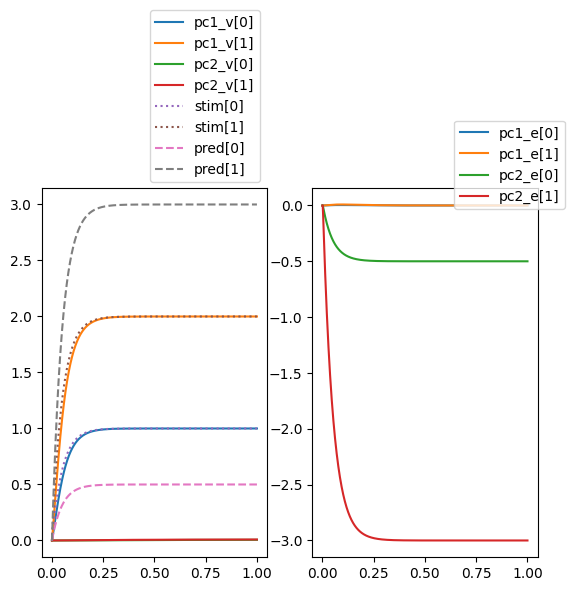

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].plot(sim.trange(), sim.data[p_pc1v]);
ax[1].plot(sim.trange(), sim.data[p_pc1e]);
ax[0].plot(sim.trange(), sim.data[p_pc_end_v]);
ax[1].plot(sim.trange(), sim.data[p_pc_end_e]);
ax[0].plot(sim.trange(), sim.data[p_stim], ':');
ax[0].plot(sim.trange(), sim.data[p_pred], "--");
ax[0].legend(['pc1_v[0]', 'pc1_v[1]', 'pc2_v[0]', 'pc2_v[1]', 'stim[0]', 'stim[1]', 'pred[0]', 'pred[1]'],
             loc='upper right', bbox_to_anchor=(1, 1.5));
ax[1].legend(['pc1_e[0]', 'pc1_e[1]', 'pc2_e[0]', 'pc2_e[1]'],
             loc='upper left', bbox_to_anchor=(0.6, 1.2));

In [10]:
sim.run(1.)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

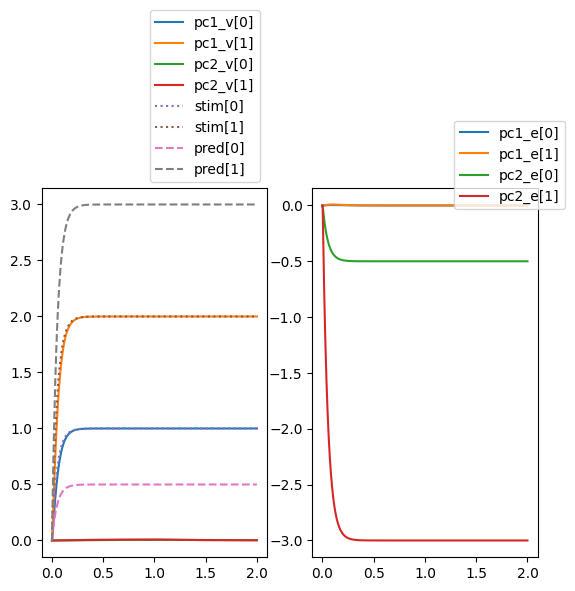

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].plot(sim.trange(), sim.data[p_pc1v]);
ax[1].plot(sim.trange(), sim.data[p_pc1e]);
ax[0].plot(sim.trange(), sim.data[p_pc_end_v]);
ax[1].plot(sim.trange(), sim.data[p_pc_end_e]);
ax[0].plot(sim.trange(), sim.data[p_stim], ':');
ax[0].plot(sim.trange(), sim.data[p_pred], "--");
ax[0].legend(['pc1_v[0]', 'pc1_v[1]', 'pc2_v[0]', 'pc2_v[1]', 'stim[0]', 'stim[1]', 'pred[0]', 'pred[1]'],
             loc='upper right', bbox_to_anchor=(1, 1.5));
ax[1].legend(['pc1_e[0]', 'pc1_e[1]', 'pc2_e[0]', 'pc2_e[1]'],
             loc='upper left', bbox_to_anchor=(0.6, 1.2));

## Learning Multiple Inputs

Given a dataset (X, Y), we want to create two dictionaries that we can pass into a nengo.processes.Piecewise object. This means that the keys must be numbers specifying the time at which to start outputting the corresponding values. The first dictionary will hold the input data, X, and the second will hold the targets, Y. We should be able to specify:
* The number of epochs to go over the dataset
* The amount of time to spend at each datapoint, subdivided into the amount of time spent stabilizing and the amount of time spent learning

What do we do about inference? Here we run into the same problem as we did with the prediction layer. We already have a node connected to the input layer giving inputs. We need to change these inputs if we want to do inference on other objects we have not seen yet. 

In [12]:
def create_learning_inputs(X, Y, epochs, stabilize_time, learn_time, shuffle=True):
    """ (np.array, np.array, int, num, num) -> (dict, dict, num)

    X                   Numpy array, datapoints to use as sensory input. Each row is a datapoint, the columns are features.
    Y                   Numpy array, targets for perception corresponding to each datapoint. Each row is a given observation's target.
    epochs              Int, the number of times to run through the dataset.
    stablize_time       Num, the amount of simulation time to spend at each datapoint without learning.
    learn_time          Num, the amount of simulation time to spend at each datapoint with learning.
    shuffle             Boolean, whether or not to shuffle the dataset at each epoch. Defaults to True.

    Returns
    x_dict              Dict, contains the data inputs.
    y_dict              Dict, contains the target vectors.
    t                   Num, the total simulation time for learning.
    """
    #our dictionaries to return
    x_dict = {}
    y_dict = {}

    #size of the dataset
    if len(X.shape) == 1:
        num_points = X.shape[0]
        num_features = 1
    else:
        num_points, num_features = X.shape
    #the size of the targets
    if len(Y.shape) == 1: #one-dimensional ouputs
        target_dimensions = 1 
    else:
        target_dimensions = Y.shape[1] 

    t = 0 #keep track of the simulation time
    point_time = stabilize_time + learn_time #the total amount of time to spend at one point

    indices = np.arange(num_points) #the indices of the datapoints

    for e in range(epochs):
        if shuffle: #shuffle the dataset each epoch
            np.random.shuffle(indices)
        for i in indices:
            if num_features == 1:
                x_dict[t] = X[i]
            else:
                x_dict[t] = X[i,:]
            if target_dimensions == 1:
                y_dict[t] = Y[i]
            else:
                y_dict[t] = Y[i,:]
            
            t += point_time #increment the time step
    
    return x_dict, y_dict, t

In [13]:
def train_network(sim, pc_net, stabilize_time, learn_time, t):
    """ (nengo.Simulator, PCNetwork, num, num, num) -> ()

    pc_net              PCNetwork, the network we wish to train.
    sim                 nengo.Simulator, the simulator created using the network we wish to train.
    stablize_time       Num, the amount of simulation time to spend at each data point without learning.
    learn_time          Num, the amount of simulation time to spend at each data point with learning.
    t                   Num, the total simulation time.

    """
    sim.run(t)
    """
    time = 0 #keep track of current time
    while time < t:
        pc_net.update_learning_rule(False)
        sim.run(stabilize_time)
        pc_net.update_learning_rule(True)
        sim.run(learn_time) 
        time += stabilize_time + learn_time
    pc_net.update_learning_rule(False) #set the network to not learn anymore
    """

In [61]:
# Using PCNetwork class
n = 1
with nengo.Network() as net:
    tau = 0.004
    #============== Run in Direct mode =======================
    net.config[nengo.Ensemble].neuron_type = nengo.LIFRate()
    #=========================================================
    net.config[nengo.Connection].synapse = tau
    net.config[nengo.Probe].synapse = 0
    
    # Inputs
    D = 2
    stab = 0
    learn = 0.5
    # our 'raw' data
    x_data = np.array([[1, 0],[0, 1]])
    y_data = np.array([[1, 0],[0, 1]])
    #create the dictionaries to pass into the piecewise functiona
    x_input, y_input, t = create_learning_inputs(x_data, y_data, 10, stab, learn, shuffle=False)
    #hardcode the inference phase
    x_input[t] = [1, 0]
    x_input[t+5] = [0, 1]
    y_input[t] = [1, 0]
    y_input[t+5] = [0, 1]
    
    stim = nengo.Node(nengo.processes.Piecewise(x_input))   # sensory (bottom layer)
    pred = nengo.Node(nengo.processes.Piecewise(y_input))  # percept (top layer)
    
    # PC layers
    PC_net = PCNetwork(n_nodes=[2, 10, 2], tau_learn=0.1, symmetric=True, activation=["tanh", None], t=t)
    PC_net.connect_input(stim=stim)
    PC_net.connect_output(pred)

    """
    [stim] <=/=> [layer 1] <=W=> [layer 2] <=W=> [layer 3] <=/= [pred]
    W are learnable weights
    """
    
 
    # Set up a bunch of probes (so we can plot stuff later)
    p_stim = nengo.Probe(stim)
    p_pc1v = nengo.Probe(PC_net.layers[0].v.output)
    p_pc1e = nengo.Probe(PC_net.layers[0].e.output)
    p_pc_end_v = nengo.Probe(PC_net.layers[-1].v.output)
    p_pc_end_e = nengo.Probe(PC_net.layers[-1].e.output)
    p_pred = nengo.Probe(pred, synapse=0)

    val_probes, err_probes = PC_net.get_probes()

In [62]:
sim = nengo.Simulator(net)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [63]:
train_network(sim, PC_net, stab, learn, t)
sim.run(10.)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Inference starts at t=10.0


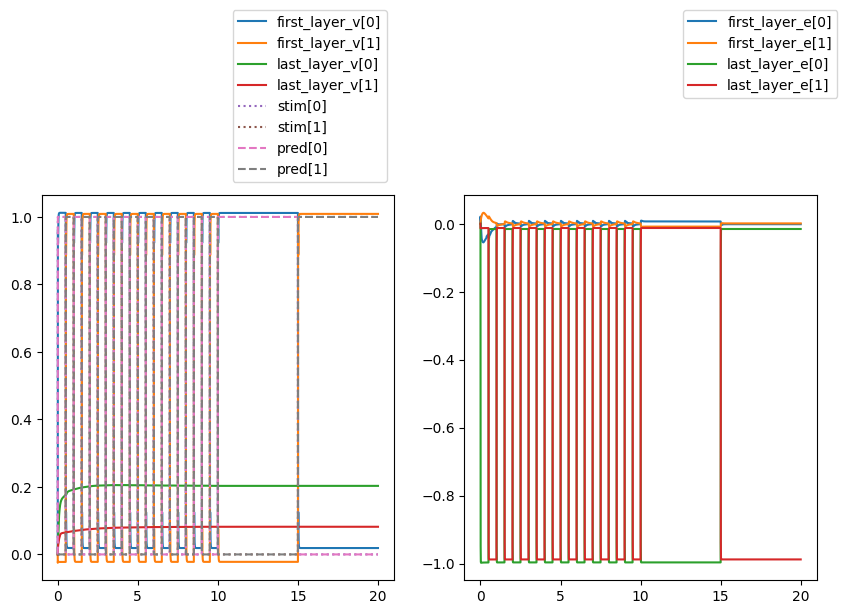

In [64]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

ax[0].plot(sim.trange(), sim.data[p_pc1v]);
ax[1].plot(sim.trange(), sim.data[p_pc1e]);
ax[0].plot(sim.trange(), sim.data[p_pc_end_v]);
ax[1].plot(sim.trange(), sim.data[p_pc_end_e]);
ax[0].plot(sim.trange(), sim.data[p_stim], ':');
ax[0].plot(sim.trange(), sim.data[p_pred], "--");
ax[0].legend(['first_layer_v[0]', 'first_layer_v[1]', 'last_layer_v[0]', 'last_layer_v[1]', 'stim[0]', 'stim[1]', 'pred[0]', 'pred[1]'],
             loc='upper right', bbox_to_anchor=(1, 1.5));
ax[1].legend(['first_layer_e[0]', 'first_layer_e[1]', 'last_layer_e[0]', 'last_layer_e[1]'],
             loc='upper left', bbox_to_anchor=(0.6, 1.5));

print(f"Inference starts at t={t}")

In [50]:
print(PC_net.connections[0].W)

[[ 0.02856721  0.03218099 -0.07377547  0.10115268  0.16064425 -0.04521006
   0.1197973   0.05476361 -0.0050796   0.16721895]
 [ 0.08906684 -0.25129122  0.11291123  0.06042973 -0.28847443 -0.00502758
   0.18600428 -0.20041553 -0.0556638   0.03796035]]


Inference starts at t=10.0


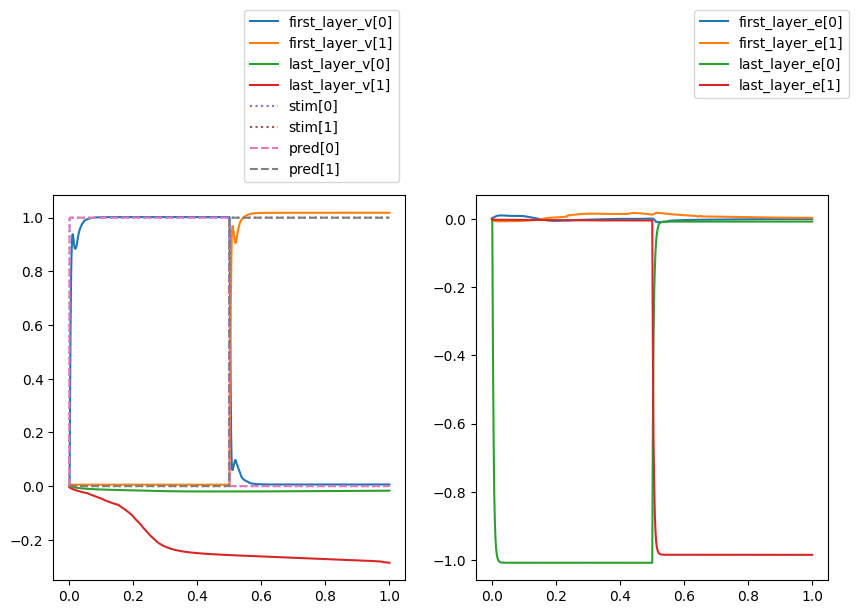

In [52]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

idx = [0, 1000]
#idx = [70000, 72000]
tt = sim.trange()[idx[0]:idx[1]]

ax[0].plot(tt, sim.data[p_pc1v][idx[0]:idx[1]]);
ax[1].plot(tt, sim.data[p_pc1e][idx[0]:idx[1]]);
ax[0].plot(tt, sim.data[p_pc_end_v][idx[0]:idx[1]]);
ax[1].plot(tt, sim.data[p_pc_end_e][idx[0]:idx[1]]);
ax[0].plot(tt, sim.data[p_stim][idx[0]:idx[1]], ':');
ax[0].plot(tt, sim.data[p_pred][idx[0]:idx[1]], "--");
ax[0].legend(['first_layer_v[0]', 'first_layer_v[1]', 'last_layer_v[0]', 'last_layer_v[1]', 'stim[0]', 'stim[1]', 'pred[0]', 'pred[1]'],
             loc='upper right', bbox_to_anchor=(1, 1.5));
ax[1].legend(['first_layer_e[0]', 'first_layer_e[1]', 'last_layer_e[0]', 'last_layer_e[1]'],
             loc='upper left', bbox_to_anchor=(0.6, 1.5));

print(f"Inference starts at t={t}")

### Try to Learn Using Pytorch and Copy the Weights

In [20]:
class TestNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(2, 2, bias=False),
            nn.Linear(2, 2, bias=False)
        )
    
    def forward(self, X):
        return self.layers(X)
    
    def train_model(self, dl, optim, loss_func, epochs):
        self.train()
        losses = []
        for e in range(epochs):
            for batch_num, (X, Y) in enumerate(dl):
                out = self(X)
                loss = loss_func(out, Y)

                loss.backward()
                optim.step()
                optim.zero_grad()
            
            losses.append(loss.item())
        return losses

NameError: name 'nn' is not defined

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        x = self.X[idx,:]
        y = self.Y[idx,:]
        return x, y

In [ ]:
X = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
Y = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
ds = CustomDataset(X, Y)
dl = torch.utils.data.DataLoader(ds, batch_size=2, shuffle=True)

In [ ]:
net = TestNN()
loss = nn.MSELoss(reduction="mean")
optim = torch.optim.SGD(net.parameters(), lr=1e-1)

In [ ]:
losses = net.train_model(dl, optim, loss, 200)

In [ ]:
plt.figure()
plt.plot(losses)
plt.ylabel("MSE Loss")
plt.xlabel("Epochs")
plt.show()

In [ ]:
net(X)

In [ ]:
W1 = list(net.layers[0].parameters())[0][:]
W2 = list(net.layers[1].parameters())[0][:]
print(W1)
print(W2)
print(W1@W2)

In [ ]:
# Using PCNetwork class
n = 1
with nengo.Network() as net:
    tau = 0.01
    #============== Run in Direct mode =======================
    net.config[nengo.Ensemble].neuron_type = nengo.Direct()
    #=========================================================
    net.config[nengo.Connection].synapse = tau
    net.config[nengo.Probe].synapse = 0.05
    
    # Inputs
    D = 2
    stab = 0
    learn = 0
    # our 'raw' data
    x_data = np.array([[1, 0],[0, 1]])
    y_data = np.array([[1, 0],[0, 1]])
    #create the dictionaries to pass into the piecewise functiona
    x_input, y_input, t = create_learning_inputs(x_data, y_data, 1, stab, learn, shuffle=True)
    #hardcode the inference phase
    x_input[t] = [1, 0]
    x_input[t+5] = [0, 1]
    y_input[t] = [1, 0]
    y_input[t+5] = [0, 1]
    
    stim = nengo.Node(nengo.processes.Piecewise(x_input))   # sensory (bottom layer)
    pred = nengo.Node(nengo.processes.Piecewise(y_input))  # percept (top layer)
    
    # PC layers
    PC_net = PCNetwork(n_nodes=[2, 2, 2], tau_learn=5, symmetric=True, activation=None, t=t)
    
    #copy connection weights
    PC_net.connections[0].W = W1.detach().numpy()
    PC_net.connections[1].W = W2.detach().numpy()
    PC_net.connections[0].M = W1.detach().numpy().T
    PC_net.connections[1].M = W2.detach().numpy().T
    
    PC_net.connect_input(stim=stim)
    PC_net.connect_output(pred)
    '''
     [     /-->         ] -W-> [      /-->       ] -W-> [      /-->       ]      [      ]
     [ stim     stim_err]      [ pc1.v     pc1.e ]      [ pc2.v     pc2.e ]      [ pred ]
     [                  ] <-M- [       <--/      ] <-M- [       <--/      ] <-M- [      ]
    '''
    
 
    # Set up a bunch of probes (so we can plot stuff later)
    p_stim = nengo.Probe(stim)
    p_pc1v = nengo.Probe(PC_net.layers[0].v.output)
    p_pc1e = nengo.Probe(PC_net.layers[0].e.output)
    p_pc_end_v = nengo.Probe(PC_net.layers[-1].v.output)
    p_pc_end_e = nengo.Probe(PC_net.layers[-1].e.output)
    p_pred = nengo.Probe(pred)

    val_probes, err_probes = PC_net.get_probes()

In [ ]:
sim = nengo.Simulator(net)

In [ ]:
sim.run(10.)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,7))

ax[0].plot(sim.trange(), sim.data[p_pc1v]);
ax[1].plot(sim.trange(), sim.data[p_pc1e]);
ax[0].plot(sim.trange(), sim.data[p_pc_end_v]);
ax[1].plot(sim.trange(), sim.data[p_pc_end_e]);
ax[0].plot(sim.trange(), sim.data[p_stim], ':');
ax[0].plot(sim.trange(), sim.data[p_pred], "--");
ax[0].legend(['pc1_v[0]', 'pc1_v[1]', 'pc2_v[0]', 'pc2_v[1]', 'stim[0]', 'stim[1]', 'pred[0]', 'pred[1]'],
             loc='upper right', bbox_to_anchor=(1, 1.5));
ax[1].legend(['pc1_e[0]', 'pc1_e[1]', 'pc2_e[0]', 'pc2_e[1]'],
             loc='upper left', bbox_to_anchor=(0.6, 1.2));

print(f"Inference starts at t={t}")

### Copying Network Weights

In [ ]:
with nengo.Network() as net_inference:
    tau = 0.01
    #============== Run in Direct mode =======================
    net.config[nengo.Ensemble].neuron_type = nengo.Direct()
    #=========================================================
    net.config[nengo.Connection].synapse = tau
    net.config[nengo.Probe].synapse = 0.05
    
    # Inputs
    stim = nengo.Node([1, 2])   # sensory (bottom layer)
    pred = nengo.Node([0.5, 3])  # percept (top layer)

    PC_net2 = PCNetwork(3, learn=False, tau_learn=100, n_nodes=[2, 5, 2], symmetric=True)
    PC_net2.connect_input(stim=stim)

    #copy connection weights over
    for idx, connection in enumerate(PC_net2.connections):
        connection.M = deepcopy(PC_net.connections[idx].M)
        connection.W = deepcopy(PC_net.connections[idx].W)

    p_stim = nengo.Probe(stim)
    p_pred = nengo.Probe(pred)

    val_probes, err_probes = PC_net2.get_probes()
    

In [ ]:
sim = nengo.Simulator(net_inference)

In [ ]:
PC_net2.update_learning_rule(False)

In [ ]:
sim.run(10.)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].plot(sim.trange(), sim.data[val_probes[0]]);
ax[1].plot(sim.trange(), sim.data[err_probes[0]]);
ax[0].plot(sim.trange(), sim.data[val_probes[-1]]);
ax[1].plot(sim.trange(), sim.data[err_probes[-1]]);

ax[0].plot(sim.trange(), sim.data[p_stim], ':');
ax[0].plot(sim.trange(), sim.data[p_pred], "--");

labels = [val_probes[i].label for i in range(len(val_probes))]
labels.extend(['stim[0]', 'stim[1]', 'pred[0]', 'pred[1]'])
ax[0].legend(['1st layer[0]', '1st layer[1]', 'last layer[0]', 'last layer[1]', 'stim[0]', 'stim[1]', 'pred[0]', 'pred[1]'],
             loc='upper right', bbox_to_anchor=(1, 1.5));
ax[1].legend([err_probes[i].label for i in range(len(err_probes))],
             loc='upper left', bbox_to_anchor=(0.6, 1.2));